# Поиск каверов композиций
<br>Разработка ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам

<br>**Описание проекта**
<br>Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей.
<br>Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков.
<br>Например:
- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

<br>**Цель проекта**
<br>Необходимо разработать ML-продукт, который:
- классифицирует треки по признаку кавер-некавер;
- связывает (группирует) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

<br>**Описание данных**
- Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:
    - track_id - уникальный идентификатор трека;
    - track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
    - original_track_id - уникальный идентификатор исходного трека.
- Метаинформация:
    - track_id - уникальный идентификатор трека;
    - dttm - первая дата появления информации о треке;
    - title - название трека;
    - language - язык исполнения;
    - isrc - международный уникальный идентификатор трека;
    - genres - жанры;
    - duration - длительность трека.
- Текст песен:
    - track_id - уникальный идентификатор трека;
    - lyricId - уникальный идентификатор текста;
    - text - текст трека.

<br>**Целевые метрики**

1. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) является метрикой, которая оценивает качество бинарной классификации, учитывая полноту (True Positive Rate) и специфичность (True Negative Rate) модели. ROC-AUC измеряет способность модели различать между классами и представляет площадь под кривой ROC. ROC-AUC особенно полезна, когда важно контролировать баланс между ложно-положительными и ложно-отрицательными предсказаниями. Она также устойчива к несбалансированным классам.
2. F1-мера является метрикой, которая оценивает точность и полноту модели для бинарной классификации. F1-мера является гармоническим средним между точностью (precision) и полнотой (recall). Она особенно полезна, когда важно достичь баланса между точностью и полнотой. F1-мера хорошо работает, когда классы сбалансированы или когда важно минимизировать как ложно-положительные, так и ложно-отрицательные предсказания.

## Импорт библиотек

In [2]:
# !pip install sentence-transformers #-U
# !pip install catboost
# # !pip install lyricsgenius
# # !pip install gensim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import torch
import warnings
import transformers
import csv
from sentence_transformers import SentenceTransformer
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


Установка констант

In [4]:
RS = 42 # random state
MAX_TOKEN_LEN = 512 # ограничение на максимальную длину токена

## EDA

### Загрузка данных

In [5]:
try:
    covers = pd.read_json('./drive/MyDrive/Colab Notebooks/music_covers/covers.json', orient='records', lines=True)
    lyrics = pd.read_json('./drive/MyDrive/Colab Notebooks/music_covers/lyrics.json', orient='records', lines=True)
    meta = pd.read_json('./drive/MyDrive/Colab Notebooks/music_covers/meta.json', orient='records', lines=True)
    print('загружено из каталога "Colab Notebooks"')
except:
    covers = pd.read_json('data/covers.json', orient='records', lines=True)
    lyrics = pd.read_json('data/lyrics.json', orient='records', lines=True)
    meta = pd.read_json('data/meta.json', orient='records', lines=True)
    print('загружено из каталога "data"')

np.array(covers).shape, np.array(lyrics).shape, np.array(meta).shape

загружено из каталога "Colab Notebooks"


((71597, 3), (11414, 3), (71769, 7))

### Датафрейм `lyrics`

In [6]:
lyrics.info()
display(lyrics.sample(3))
print('явные повторы строк:', lyrics.duplicated().sum())
display('количество уникальных записей:', lyrics.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
4570,549295664746b686e85e1398961df48b,"Remember the words you told me\n""Love me 'til ...",451e6ebcd6653991ae1a9f1d97d533cc
8699,cdef1c432f5ccdf247b1d7479a5a67bc,If I could write you a song to make you fall i...,884455d212afd5f339a98d55699d9c02
1580,4609d2dfa5a866067377accaff045cb8,Болит душа от потерь\nВерю я — ты тоже верь\nН...,b10e383b6a2a8a6ecd808ca642dac670


явные повторы строк: 0


'количество уникальных записей:'

lyricId     10915
text        10644
track_id    10277
dtype: int64

Выводы:
- тексты представлены на различных языках (английский, русский, испанский и др.)
- явных повторов строк не обнаружено, при этом количество уникальных ID текстов и треков меньше,
  <br>чем всего строк, что означает использование текстов в других треках

### Датафрейм `meta`

In [7]:
meta.info()
display(meta.sample()) #genres - list
print('явные повторы строк:', meta[['track_id', 'dttm', 'title', 'language', 'isrc', 'duration']].duplicated().sum())
display('количество уникальных записей:', meta[['track_id', 'dttm', 'title', 'language', 'isrc', 'duration']].nunique())
display('список представленных стран:', meta['language'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
36251,ea7ce18d846ae26a8d067fa4b1608bf4,1.633643e+12,ChalkZone,None,QZPJ32110919,[RAP],37670.0


явные повторы строк: 0


'количество уникальных записей:'

track_id    71768
dttm        27726
title       45462
language       85
isrc        71283
duration    23597
dtype: int64

'список представленных стран:'

array(['EN', None, 'ES', 'HI', 'DE', 'RU', 'TR', 'HU', 'TH', 'PL', 'FR',
       'NY', 'AF', 'AS', 'UZ', 'HT', 'EL', 'AZ', 'IT', 'PA', 'PT', 'TA',
       'JA', 'ML', 'VI', 'ID', 'LA', 'CS', 'SI', 'UK', 'OR', 'HR', 'AR',
       'KK', 'FI', 'IE', 'ZH', 'AB', 'KN', 'FA', 'BN', 'TL', 'SK', 'KS',
       'SV', 'RO', 'TN', 'KO', 'MS', 'BM', 'HY', 'TW', 'MY', 'CA', 'NL',
       'ET', 'TE', 'MN', 'HE', 'SQ', 'IG', 'MR', 'BE', 'LT', 'UR', 'IA',
       'GN', 'SW', 'NO', 'GU', 'KY', 'KU', 'IS', 'TG', 'SR', 'DA', 'LO',
       'LV', 'SE', 'WO', 'SA', 'YO', 'ST', 'HA', 'AV', 'IU'], dtype=object)

In [ ]:
# from datetime import datetime

# unix_timestamp1 = 1.555760e+12
# unix_timestamp2 = 1.626110e+12

# # Преобразование временной метки в объект datetime
# dt1 = datetime.fromtimestamp(unix_timestamp1 / 1000) #2019-04-20 14:33:20
# dt2 = datetime.fromtimestamp(unix_timestamp2 / 1000) #2021-07-12 20:13:20

# print(dt1 < dt2) #True
# unix_timestamp1 < unix_timestamp2 #True

Выводы:
- явных повторов строк не обнаружено
- количество стран в колонке `language` - 85
- информация о странах внесена менее, чем в 30% записей
- все `track_id` уникальны
- даты представлены в unix формате
- можно удалить признаки:
  - `duration` - не несёт важной информации, т.к. продолжительность кавера может отличаться от исходника
  - `genres` - не несёт важной информации, т.к. жанр кавера может отличаться от исходника
  - `isrc` - не несёт важной информации, т.к. имеется признак `track_id`, а ещё в нём есть пропуски

### Датафрейм `covers`

In [8]:
covers.info()
display(covers.sample())
print('явные повторы строк:', covers.duplicated().sum())
display('количество уникальных записей:', covers.nunique())
print('оригинальных треков указано:', round(covers['original_track_id'].count() / covers['track_id'].count() * 100, 2), '% записей')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


,original_track_id,track_id,track_remake_type
56109,None,cf61765f11a9fe14707b578e17846c31,COVER


явные повторы строк: 0


'количество уникальных записей:'

original_track_id     4468
track_id             71597
track_remake_type        2
dtype: int64

оригинальных треков указано: 6.73 % записей


Выводы:
- явных повторов строк не обнаружено
- количество указанных оригинальных треков - 6.73 % от общего числа треков

In [9]:
filled_data = covers.dropna(subset=['track_remake_type'])
filled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


### Объединение датафреймов

In [10]:
cover_lyric = (filled_data
               .merge(lyrics, on='track_id', how='left')
               .merge(meta[['track_id', 'dttm', 'duration']], on='track_id', how='left')
              ) # объединение по левой таблице

In [11]:
cover_lyric_wona = cover_lyric.dropna(subset=['text']).reset_index(drop=True) # удаление пропусков
cover_lyric_wona = cover_lyric_wona.drop(['lyricId'], axis=1) # удаление колонки lyricId
cover_lyric_wona.shape

(11097, 6)

In [12]:
display('количество уникальных записей:', cover_lyric_wona.nunique())

'количество уникальных записей:'

original_track_id     2824
track_id             10123
track_remake_type        2
text                 10385
dttm                  4668
duration              7498
dtype: int64

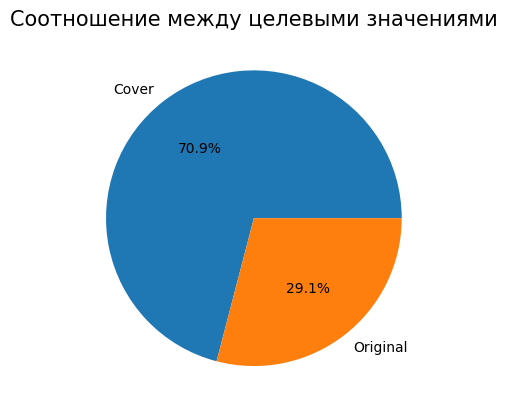

In [13]:
labels = 'Cover', 'Original'
sizes = [cover_lyric_wona['track_remake_type'].value_counts()[0], cover_lyric_wona['track_remake_type'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Соотношение между целевыми значениями', size=15)
plt.show()

Вывод:
- данные объединены с сохранением признака кавера
- из данных удалены пропущенные значения
- удалены ненужные признаки

### Кодирование текстов

#### SentenceTransformer

In [14]:
sentences = np.array(cover_lyric_wona['text'])

# model = SentenceTransformer('all-MiniLM-L6-v2')  # архитектура MiniLM (время выполнения ~ 1 мин)
model = SentenceTransformer('sentence-transformers/LaBSE')  # архитектура LaBSE (Language-agnostic BERT Sentence Embedding) (~ 5 мин)
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

(11097, 768)

Вывод:
- получены эмбеддинги текстов при помощи библиотеки `sentence_transformer` на архитектуре LaBSE
- выбор данной архитектуры обусловлен её способностью распознавать и сравнивать тексты на более, чем 100 языках
- затраченное на обучение время: 5 минут

Соединение закодированных текстов с исходными данными

In [15]:
df_work = cover_lyric_wona.copy()
df_work = df_work.join(pd.DataFrame(sentence_embeddings), how='left')
print(df_work.shape)
df_work = df_work.loc[:10999] # данные до 11000
print(df_work.shape)
df_work.head(3)

(11097, 774)
(11000, 774)


,original_track_id,track_id,track_remake_type,text,dttm,duration,0,1,2,3,...,758,759,760,761,762,763,764,765,766,767
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,Left a good job in the city\nWorkin' for the m...,1.257973e+12,187220.0,-0.071151,-0.000550,-0.015525,-0.068183,...,0.037262,-0.010959,0.025177,0.026895,0.004867,-0.043662,-0.015377,-0.008442,-0.041558,-0.055484
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,Left a good job in the city\nWorkin' for the m...,1.257973e+12,187220.0,-0.072601,-0.008105,-0.007002,-0.066120,...,0.040421,-0.008107,0.017281,0.025594,0.005750,-0.043891,-0.017041,-0.004621,-0.034674,-0.053124
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,Some folks are born made to wave the flag\nOoh...,1.257973e+12,137780.0,-0.053419,-0.000123,-0.033951,-0.025266,...,-0.007231,0.005841,-0.020928,0.031590,0.011153,-0.046689,0.015612,0.051465,-0.066878,-0.074791


Вывод:
- закодированные тексты присоединены к основному датафрейму

#### Bert transformer

In [16]:
cover_lyric_wona_r = cover_lyric_wona.loc[:10999] # данные до 11000
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenized = cover_lyric_wona_r['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Token indices sequence length is longer than the specified maximum sequence length for this model (815 > 512). Running this sequence through the model will result in indexing errors


Применение паддинга к векторам

In [17]:
padded = np.array([i[:MAX_TOKEN_LEN] + [0]*(MAX_TOKEN_LEN - len(i[:MAX_TOKEN_LEN]))\
                   if len(i) > MAX_TOKEN_LEN else i + [0]*(MAX_TOKEN_LEN - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
attention_mask = torch.tensor(attention_mask, dtype=torch.long).to(device)

Инициализируем модель класса BertModel. Передадим ей файл с предобученной моделью

In [18]:
model_bert = transformers.BertModel.from_pretrained('bert-base-multilingual-cased').to(device)

Преобразование текстов в эмбеддинги

In [19]:
batch_size = 100
bert_embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
  batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
  attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)]
  with torch.no_grad():
    batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
    bert_embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/110 [00:00<?, ?it/s]

Функция для разделения списков

In [20]:
def f(gen):
    return pd.Series(gen, dtype='float64')

Добавление эмбеддингов к датафрейму

In [21]:
bert_embedding = np.concatenate(bert_embeddings) # сбор в матрицу

In [22]:
df_e = cover_lyric_wona_r[['text', 'track_remake_type', 'duration']] # эмбендинги общим списком
df_e['embedding'] = bert_embedding.tolist() # преобразование в список
ren = df_e['embedding'].apply(f) # применение функции разделения

df_o = cover_lyric_wona_r.copy() # создание нового датафрейма
df_o = df_o.drop('text', axis=1)

df_o = pd.concat([df_o, ren], axis=1) # Добавление новых столбцов к датафрейму

display('количество пропущенных значений:', df_o.isna().sum().sum())
df_o.shape

'количество пропущенных значений:'

7477

(11000, 773)

Вывод:
- получены эмбеддинги текстов при помощи мультиязычного трансформера на базе Bert
- эмбеддинги добавлены к основным данным
- затраченное на обучение время: 5 минут

### Подготовка к обучению

In [23]:
print('соотношение классов df_work (ST):', round(df_work['track_remake_type'].value_counts()[1] / df_work['track_remake_type'].value_counts()[0], 2))
print('соотношение классов df_o (BT):', round(df_o['track_remake_type'].value_counts()[1] / df_o['track_remake_type'].value_counts()[0], 2))

соотношение классов df_work (ST): 0.4
соотношение классов df_o (BT): 0.4


In [24]:
df_work.sample()

,original_track_id,track_id,track_remake_type,text,dttm,duration,0,1,2,3,...,758,759,760,761,762,763,764,765,766,767
7598,None,2b1fd0250d6fe9faf3c3b9330f8f4e7c,COVER,"Any other day, I would call, you would say\n""B...",1.620421e+12,267390.0,-0.039714,-0.045117,-0.010637,-0.061123,...,0.023064,-0.040145,-0.00738,0.038036,-0.026472,-0.03691,0.016246,0.019189,-0.056845,-0.040867


In [25]:
df_o.sample()

,original_track_id,track_id,track_remake_type,dttm,duration,0,1,2,3,4,...,758,759,760,761,762,763,764,765,766,767
4713,ba98fefb3d209d940088d954483642ad,ba98fefb3d209d940088d954483642ad,ORIGINAL,1.547524e+12,237360.0,-0.02637,0.216165,0.105612,-0.048529,0.21955,...,0.096062,-0.023205,-0.154446,-0.388967,-0.149774,0.030577,0.156767,0.044125,-0.344088,-0.004262


Вывод:
- в данных наблюдается дисбаланс классов
- при разделении на выборки необходимо учесть этот момент

## Machine learning

In [26]:
# данные на эмбеддингах sentencetransformer
df_tr = df_work.copy()
X = df_tr.drop(['original_track_id', 'track_id', 'track_remake_type', 'text'], axis=1)
y = df_tr['track_remake_type']
y = (y != 'ORIGINAL').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RS,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8800, 770), (2200, 770), (8800,), (2200,))

In [27]:
# данные на эмбеддингах bert transformer
df_tr_b = df_o.copy()
X_bert_em = df_tr_b.drop(['original_track_id', 'track_id', 'track_remake_type'], axis=1)
y_bert_em = df_tr_b['track_remake_type']
y_bert_em = (y_bert_em != 'ORIGINAL').astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bert_em,
                                                            y_bert_em,
                                                            test_size=0.2,
                                                            random_state=RS,
                                                            stratify=y_bert_em)
X_train_b.shape, X_test_b.shape, y_train_b.shape, y_test_b.shape

((8800, 770), (2200, 770), (8800,), (2200,))

In [28]:
# для кластеризации общие данные
X_train_k = X_train.iloc[:,:2]
X_train_k = (X_train_k
             .merge(df_tr[['original_track_id', 'track_id']], left_index=True, right_index=True, how='left')
             .merge(y_train, left_index=True, right_index=True, how='left'))

Вывод:
- данные поделены на обучающую и тестовую выборки с учётом дисбаланса классов

### XGBoost на эмбеддингах SentenceTransformer

In [29]:
# Преобразование данных в формат DMatrix
dtrain = xgboost.DMatrix(X_train, label=y_train)
dtest = xgboost.DMatrix(X_test, label=y_test)

# Определение параметров модели
params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 3,
    'random_state': RS
}

# Обучение модели
xgb_st = xgboost.train(params_xgb, dtrain, evals=[(dtest, 'Test')], num_boost_round=1000, verbose_eval=100)

# Получение предсказаний на тестовом наборе данных
y_pred_xgb_st = xgb_st.predict(dtest)
y_pred_xgb_st_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb_st]

# Вычисление ROC-AUC
auc_xgb_st = roc_auc_score(y_test, y_pred_xgb_st)
print('ROC-AUC:', round(auc_xgb_st, 4))

# Вычисление F1-меры
f1_xgb_st = f1_score(y_test, y_pred_xgb_st_binary)
print("F1-мера:", round(f1_xgb_st, 4))

[0]	Test-auc:0.75449
[100]	Test-auc:0.90766
[200]	Test-auc:0.91610
[300]	Test-auc:0.92010
[400]	Test-auc:0.92294
[500]	Test-auc:0.92389
[600]	Test-auc:0.92629
[700]	Test-auc:0.92814
[800]	Test-auc:0.92797
[900]	Test-auc:0.92830
[999]	Test-auc:0.92868
ROC-AUC: 0.9287
F1-мера: 0.9163


Вывод:
- при обучении `XGBoost` на эмбеддингах `SentenceTransformer` получены метрики `ROC-AUC: 0.9287`, `F1-мера: 0.9163` на тестовых данных

### XGBoost на эмбеддингах Bert

In [30]:
# Преобразование данных в формат DMatrix
dtrain_b = xgboost.DMatrix(X_train_b, label=y_train_b)
dtest_b = xgboost.DMatrix(X_test_b, label=y_test_b)

# Обучение модели
xgb_b = xgboost.train(params_xgb, dtrain_b, evals=[(dtest_b, 'Test')], num_boost_round=1000, verbose_eval=100)

# Получение предсказаний на тестовом наборе данных
y_pred_xgb_b = xgb_b.predict(dtest_b)
y_pred_xgb_b_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb_b]

# Вычисление ROC-AUC
auc_xgb_b = roc_auc_score(y_test_b, y_pred_xgb_b)
print('ROC-AUC:', round(auc_xgb_b, 4))

# Вычисление F1-меры
f1_xgb_b = f1_score(y_test_b, y_pred_xgb_b_binary)
print("F1-мера:", round(f1_xgb_b, 4))

[0]	Test-auc:0.77045
[100]	Test-auc:0.91248
[200]	Test-auc:0.91857
[300]	Test-auc:0.92102
[400]	Test-auc:0.92230
[500]	Test-auc:0.92198
[600]	Test-auc:0.92261
[700]	Test-auc:0.92373
[800]	Test-auc:0.92415
[900]	Test-auc:0.92464
[999]	Test-auc:0.92529
ROC-AUC: 0.9253
F1-мера: 0.9197


Вывод:

- при обучении `XGBoost` на эмбеддингах `Bert` получены метрики `ROC-AUC: 0.9253`, `F1-мера: 0.9197` на тестовых данных

### CatBoost на эмбеддингах Bert

In [31]:
cb_b = CatBoostClassifier(random_state=RS, eval_metric='AUC') # инициализация модели
cb_b.fit(X_train_b, y_train_b, eval_set=(X_test_b, y_test_b), verbose=100, plot=True) # обучение модели

# Вычисление и вывод ROC-AUC
y_pred_proba_cb_b = cb_b.predict_proba(X_test_b)[:, 1]
roc_auc_cb_b = roc_auc_score(y_test_b, y_pred_proba_cb_b)
print("ROC-AUC на тестовой выборке:", roc_auc_cb_b)

# Вычисление F1-меры
y_pred_cb_b = cb_b.predict(X_test_b) # получение предсказаний на тестовой выборке
y_pred_cb_b_binary = [1 if p >= 0.5 else 0 for p in y_pred_cb_b]
f1_cb_b = f1_score(y_test_b, y_pred_cb_b_binary)
print("F1-мера на тестовой выборке:", f1_cb_b)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.054225
0:	test: 0.7647068	best: 0.7647068 (0)	total: 312ms	remaining: 5m 11s
100:	test: 0.9049358	best: 0.9053281 (98)	total: 23.9s	remaining: 3m 33s
200:	test: 0.9156597	best: 0.9157406 (199)	total: 44.1s	remaining: 2m 55s
300:	test: 0.9208705	best: 0.9208705 (300)	total: 1m 4s	remaining: 2m 29s
400:	test: 0.9231766	best: 0.9233485 (396)	total: 1m 26s	remaining: 2m 9s
500:	test: 0.9261925	best: 0.9262046 (499)	total: 1m 47s	remaining: 1m 46s
600:	test: 0.9271681	best: 0.9272409 (598)	total: 2m 12s	remaining: 1m 27s
700:	test: 0.9279112	best: 0.9279112 (700)	total: 2m 34s	remaining: 1m 5s
800:	test: 0.9283642	best: 0.9287413 (792)	total: 2m 54s	remaining: 43.4s
900:	test: 0.9290244	best: 0.9291518 (897)	total: 3m 18s	remaining: 21.8s
999:	test: 0.9301041	best: 0.9301041 (999)	total: 3m 39s	remaining: 0us

bestTest = 0.9301041351
bestIteration = 999

ROC-AUC на тестовой выборке: 0.930104135072288
F1-мера на тестовой выборке: 0.9219467401285584


Вывод:
- при обучении `CatBoost` на эмбеддингах `Bert` получены метрики `ROC-AUC: 0.93`, `F1-мера: 0.92` на тестовых данных

### CatBoost на эмбеддингах SentenceTransformer

In [32]:
cb_st = CatBoostClassifier(random_state=RS, eval_metric='AUC') # инициализация модели
cb_st.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100, plot=True) # обучение модели

# Вычисление и вывод ROC-AUC
y_pred_proba_cb_st = cb_st.predict_proba(X_test)[:, 1]
roc_auc_cb_st = roc_auc_score(y_test, y_pred_proba_cb_st)
print("ROC-AUC на тестовой выборке:", roc_auc_cb_b)

# Вычисление F1-меры
y_pred_cb_st = cb_st.predict(X_test) # получение предсказаний на тестовой выборке
y_pred_cb_st_binary = [1 if p >= 0.5 else 0 for p in y_pred_cb_st]
f1_cb_st = f1_score(y_test, y_pred_cb_st_binary)
print("F1-мера на тестовой выборке:", f1_cb_st)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.054225
0:	test: 0.7572854	best: 0.7572854 (0)	total: 438ms	remaining: 7m 17s
100:	test: 0.8959509	best: 0.8959509 (100)	total: 22s	remaining: 3m 15s
200:	test: 0.9147791	best: 0.9147791 (200)	total: 42.2s	remaining: 2m 47s
300:	test: 0.9228673	best: 0.9228673 (300)	total: 1m 4s	remaining: 2m 30s
400:	test: 0.9281114	best: 0.9281377 (399)	total: 1m 25s	remaining: 2m 7s
500:	test: 0.9300435	best: 0.9301597 (492)	total: 1m 45s	remaining: 1m 45s
600:	test: 0.9315479	best: 0.9317895 (588)	total: 2m 8s	remaining: 1m 25s
700:	test: 0.9330159	best: 0.9330735 (699)	total: 2m 29s	remaining: 1m 3s
800:	test: 0.9334253	best: 0.9334253 (800)	total: 2m 54s	remaining: 43.2s
900:	test: 0.9342827	best: 0.9343373 (884)	total: 3m 16s	remaining: 21.6s
999:	test: 0.9348175	best: 0.9350318 (955)	total: 3m 36s	remaining: 0us

bestTest = 0.9350318471
bestIteration = 955

Shrink model to first 956 iterations.
ROC-AUC на тестовой выборке: 0.930104135072288
F1-мера на тестовой выборке: 0.9

Вывод:

- при обучении `CatBoost` на эмбеддингах `SentenceTransformer` получены метрики `ROC-AUC: 0.93`, `F1-мера: 0.9181` на тестовых данных

### LogisticRegression на эбеддингах Bert

F1-мера на обучающей выборке: 0.8329686360320933
F1-мера на тестовой выборке: 0.8328912466843501
ROC-AUC на тестовой выборке: 0.39


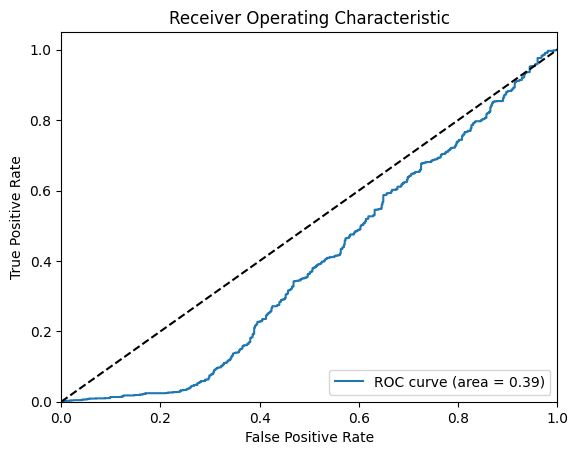

In [34]:
model_lg = LogisticRegression(random_state=RS, max_iter=1000)
model_lg.fit(X_train_b.values, y_train_b)

y_pred_tr_lg = model_lg.predict(X_train_b.values) # предсказания на обучающей выборке

# Вычисление F1-меры для обучабщей выыборки
y_pred_binary_lg = [1 if p >= 0.5 else 0 for p in y_pred_tr_lg]
f1_tr_lg_b = f1_score(y_train_b, y_pred_binary_lg)
print("F1-мера на обучающей выборке:", f1_tr_lg_b)

# Вычисление F1-меры для тестовой выборки
y_pred_t = model_lg.predict(X_test_b.values)
y_pred_binary_tlg = [1 if p >= 0.5 else 0 for p in y_pred_t]
f1_t_lg_b = f1_score(y_test_b, y_pred_binary_tlg)
print("F1-мера на тестовой выборке:", f1_t_lg_b)

# Вычисление ROC-AUC
y_pred_proba_lg = model_lg.predict_proba(X_test_b.values)[:, 1]
roc_auc_lg = roc_auc_score(y_test_b, y_pred_proba_lg)
print("ROC-AUC на тестовой выборке:", round(roc_auc_lg, 2))

# Визуализация кривой ROC
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test_b, y_pred_proba_lg)
plt.plot(fpr_lg, tpr_lg, label='ROC curve (area = %0.2f)' % roc_auc_lg)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Вывод:

- при обучении `LogisticRegression` на эмбеддингах `Bert Transformer` получены метрики `ROC-AUC: 0.39`, `F1-мера: 0.83` на тестовых данных
- низкое значение `ROC-AUC` может быть следствием нелинейности данных и дисбаланса классов

### LogisticRegression на эмбеддингах SentenceTransformer

F1-мера на обучающей выборке: 0.8329686360320933
F1-мера на тестовой выборке: 0.8328912466843501
ROC-AUC на тестовой выборке: 0.39


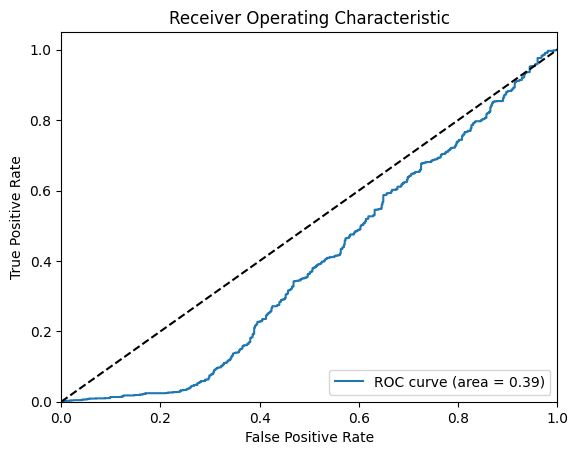

In [35]:
lg_st = LogisticRegression(random_state=RS, max_iter=1000)
lg_st.fit(X_train.values, y_train)

y_pred_tr_lg_st = lg_st.predict(X_train.values) # предсказания на обучающей выборке

# Вычисление F1-меры для обучабщей выыборки
y_pred_lg_st_binary = [1 if p >= 0.5 else 0 for p in y_pred_tr_lg_st]
f1_tr_lg_st = f1_score(y_train, y_pred_lg_st_binary)
print("F1-мера на обучающей выборке:", f1_tr_lg_st)

# Вычисление F1-меры для тестовой выборки
y_pred_t_lg_st = lg_st.predict(X_test.values)
y_pred_t_lg_st_binary = [1 if p >= 0.5 else 0 for p in y_pred_t_lg_st]
f1_t_lg_st = f1_score(y_test, y_pred_t_lg_st_binary)
print("F1-мера на тестовой выборке:", f1_t_lg_st)

# Вычисление ROC-AUC
y_pred_proba_lg_st = lg_st.predict_proba(X_test.values)[:, 1]
roc_auc_lg_st = roc_auc_score(y_test, y_pred_proba_lg_st)
print("ROC-AUC на тестовой выборке:", round(roc_auc_lg_st, 2))

# Визуализация кривой ROC
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_proba_lg_st)
plt.plot(fpr_lg, tpr_lg, label='ROC curve (area = %0.2f)' % roc_auc_lg_st)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Вывод:

- при обучении `LogisticRegression` на эмбеддингах `SentenceTransformer` получены метрики `ROC-AUC: 0.39`, `F1-мера: 0.83` на тестовых данных
- низкое значение ROC-AUC может быть следствием нелинейности данных и дисбаланса классов

### Сводные данные

In [36]:
dict2 = {'Catboost + Bert Transformer': [f1_cb_b, roc_auc_cb_b],
         'XGBoost + Bert Transformer': [f1_xgb_b, auc_xgb_b],
         'Catboost + SentenceTransformer': [f1_cb_st, roc_auc_cb_st],
         'XGBoost + SentenceTransformer': [f1_xgb_st, auc_xgb_st],
         'LogisticRegression + Bert Transformer': [f1_t_lg_b, roc_auc_lg],
         'LogisticRegression + SentenceTransformer': [f1_t_lg_st, roc_auc_lg_st]}
summary_data = (pd.DataFrame.from_dict(dict2, orient='index',
                                      columns=["F1", "ROC-AUC"]).reset_index()
                                      .rename(columns={'index': 'model'})
                                      )
summary_data

,model,F1,ROC-AUC
0,Catboost + Bert Transformer,0.921947,0.930104
1,XGBoost + Bert Transformer,0.919717,0.925293
2,Catboost + SentenceTransformer,0.918113,0.935032
3,XGBoost + SentenceTransformer,0.916308,0.928676
4,LogisticRegression + Bert Transformer,0.832891,0.393827
5,LogisticRegression + SentenceTransformer,0.832891,0.393827


## Кластеризация DBSCAN

Данные для кластеризации

In [37]:
df_kl=X_train_k.copy()
feature_o = X_train

Обучение модели

In [38]:
dbscan = DBSCAN(eps=0.3, min_samples=2)
dbscan.fit(feature_o.values)
labels = dbscan.labels_
df_kl['labels'] = labels

Поиск трека в кластере с наиболее ранней датой

In [39]:
min_date_rows = df_kl.groupby('labels')['dttm'].idxmin()
earliest_dates = df_kl.loc[min_date_rows]

Добавление метки оригинала

In [40]:
earliest_dates['target_labels'] = '0 ORIGINAL'
earliest_dates['or_tr_ID'] = earliest_dates['track_id']
dict_or = dict(zip(earliest_dates['labels'], earliest_dates['or_tr_ID'])) # создание словаря

Добавление информации к  исходным данным

In [41]:
# объединим таблицы
df_kl = df_kl.merge(earliest_dates[['target_labels', 'or_tr_ID']], left_index=True, right_index=True, how='left')
# заполним столбец ID оригинального трека
df_kl['or_tr_ID'] = df_kl['labels'].map(dict_or)
# укажем каверы
df_kl['target_labels'].fillna('1 COVER', inplace=True)
# определение треков не вошедших в кластеры
df_kl.loc[df_kl['labels'] == -1, ['target_labels', 'or_tr_ID']]  = '-'
df_kl = df_kl.drop(['dttm', 'duration'], axis=1) # удалим ненужную информацию
'кластеры и количество треков в них:', df_kl['labels'].value_counts()

('кластеры и количество треков в них:',
 -1       4607
  20        98
  99        74
  28        57
  57        53
          ... 
  540        2
  541        2
  542        2
  544        2
  1125       2
 Name: labels, Length: 1127, dtype: int64)

Проверка полученных кластеров

In [42]:
# полученные кластеры
df_kl[df_kl['labels'] >= 0].sort_values(by='labels').sample(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
5335,None,0582914919c59f255a0c5b0247e01906,1,35,1 COVER,38994d8468271569097b8319dcb1b4ea
7827,cf5fed3455a5eac210ef943b5cde5625,cf5fed3455a5eac210ef943b5cde5625,0,6,1 COVER,2edfe1bff0565baf07363fb4e28eb95e
1489,None,181ee6bb651962b1065227f2ba29e5fb,1,514,0 ORIGINAL,181ee6bb651962b1065227f2ba29e5fb
4614,None,beabdad8ce6822b8e1b56ccb8d0b89c6,1,398,1 COVER,1a7a715f42b5f6b2ec56465d5ed897f2
8069,None,85ca2c5d320d15c974af7930d0bac98e,1,6,1 COVER,2edfe1bff0565baf07363fb4e28eb95e


In [43]:
df_kl[df_kl['target_labels'] != '-'].sample(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
8517,None,2b20a7fb8f644ef345492ee6d861af07,1,121,1 COVER,46afc6cdfaae3dfbde0776b9b2e9ae8f
2274,None,c3047b0018ecde22f44357ea7b159a1b,1,826,1 COVER,c3047b0018ecde22f44357ea7b159a1b
8069,None,85ca2c5d320d15c974af7930d0bac98e,1,6,1 COVER,2edfe1bff0565baf07363fb4e28eb95e
3083,None,a64104012f532931a251ca9128d76ca7,1,808,0 ORIGINAL,a64104012f532931a251ca9128d76ca7
532,None,81fc425f0de19fc76cedb36a6064a894,1,99,1 COVER,24546925aa09160b336065943da0161d


In [44]:
# количество правильно определенных original_track_id	(8,6%) в общей численности - 8800
(df_kl['original_track_id'] == df_kl['or_tr_ID']).value_counts()

False    8047
True      753
dtype: int64

In [45]:
orig = df_kl[df_kl['original_track_id'].notnull()]
orig.head(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
9772,1b20046d1401fad20997960f00c2e2b2,1b20046d1401fad20997960f00c2e2b2,0,-1,-,-
9760,10c31ae14820dabb1205f8cf646360b4,10c31ae14820dabb1205f8cf646360b4,0,-1,-,-
1522,951edd96627f47b783716a54d2368d7b,951edd96627f47b783716a54d2368d7b,0,3,0 ORIGINAL,951edd96627f47b783716a54d2368d7b
4220,a76ea1ec728632135e72fc76c27a7fa9,a76ea1ec728632135e72fc76c27a7fa9,0,-1,-,-
7663,e3dc2ec24a07c8de52051cea81f2797c,e3dc2ec24a07c8de52051cea81f2797c,0,-1,-,-


In [46]:
# количество правильно определенных original_track_id	(26,7%) в численности original_track_id - 2822
(orig['original_track_id'] == orig['or_tr_ID']).value_counts()

False    2069
True      753
dtype: int64

Для лучших результатов следует попробовать поменять параметры кластеризаци: eps - радиус окрестности для определения плотности  min_samples - минимальное количество соседей (сейчас эти значения (0.3, 2))

Вывод:
- для кластеризации данных применена библиотека DBSCAN
- положительных результатов пока не удалось добиться

## Заключение:
- в решении поставленной задачи основными признаками приняты текст и дата появления трека
- целевой метрикой выбрана roc-auc, т.к. она устойчива к дисбалансу классов, который присущ предоставленным данным
- при кодировании текстов использованы два трансформера: SentenceTransformer, Bert transformer
- для обучения использовались признаки: дата выхода трека, эмбеддинги
- целевой признак - метка оригинал/кавер
- удалённые признаки:
  - ID треков и текстов (чтобы модель была более универсальной)
  - текст - удалён, т.к. есть его эмбеддинги
  - язык, продолжительность, жанр - удалены, т.к. сами по себе данные признаки не информативны для решения поставленной задачи
- при обучении выбирали лучшую из моделей: XGBoost, CatBoost, LogisticRegression
- наилучший результат по выбранной метрике показала модель: CatBoost на эмбеддингах, полученных через Bert Transformer
- не реализованные идеи:
  - пробовали использовать библиотеку MusicMetaLinker для обогащения предоставленных данных, но для полноценного использования не хватило отведённого времени
  - рассматривали алгоритм Doc2Vec, для полноценного изучения не хватило времени
  - кластеризация данных библиотекой DBScan, для полноценного изучения не хватило времени